# DATA2001 Assignment 2 (Weight: 25%)


The aim of this assignment is to gain practical experience in analysing unstructured data.
You should only submit your completed Jupyter notebook in .ipynb format via Blackboard, including written answers in markdown and results from executed code cells.


The assignment comprises 5 main tasks: Data Exploration, Data Preprocessing, Model Training, Model Evaluation, and Model Analysis. You will address and compare two tasks: sentiment analysis and rating prediction.


The dataset you will work with in this assignment comprises text reviews about various android applications and their corresponding ratings. Further information about the dataset can be found [here](https://huggingface.co/datasets/sealuzh/app_reviews).


# Table of Contents
1. [Task1 Data Preparation](#1.-Data-Exploration)
2. [Task2 Data Preprocessing](#2.-Data-Preprocessing)
3. [Task3 Model Training](#3.-Model-Training)
4. [Task4 Model Evaluation](#4.-Model-Evaluation)
5. [Task5 Model Analysis](#5.-Model-Analysis)

# 1. Data Exploration

1. Load the dataset from the file "app_review.csv".
2. How many records does the dataset contain?
3. How many distinct classes are there in the dataset?
4. Randomly select and print 5 reviews with a rating of '1' and 5 reviews with a rating of '5'.

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
# 1. Load the dataset
data = pd.read_csv("app_review.csv")

# 2. Number of Record
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57613 entries, 0 to 57612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  57608 non-null  object
 1   Rating  57613 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 900.3+ KB


**Column Descriptions**
1. **Review**: People`s comment
2. **Rating**: People gave the rating from 1 to 5.

There are 57613 records.

In [4]:
# 2. How many records does the dataset contain?
num_records = len(data)
print(f"2. Number of records in the dataset: {num_records}")

# 3. How many distinct classes are there in the dataset?
distinct_classes = data['Rating'].nunique()
print(f"3. Number of distinct classes in the dataset: {distinct_classes}")

2. Number of records in the dataset: 57613
3. Number of distinct classes in the dataset: 5


In [5]:
# 4. Randomly select and print 5 reviews with a rating of '1' and 5 reviews with a rating of '5'
rating_1_reviews = data[data['Rating'] == 1].sample(5, random_state=2001)
rating_5_reviews = data[data['Rating'] == 5].sample(5, random_state=2001)

print("5 Reviews with a Rating of 1:")
print(rating_1_reviews['Review'])

print("\n5 Reviews with a Rating of 5:")
print(rating_5_reviews['Review'])

5 Reviews with a Rating of 1:
1249    Used to love I used to love this app  but it a...
4061    Worst experience The app got hanged in my redm...
3590                            I Hate it Can Fix THE LAG
1794    It's showing incorrect contact name for text m...
5034    Poor app I'm sorry to say that like the websit...
Name: Review, dtype: object

5 Reviews with a Rating of 5:
25648    Been using it for years I only use this ringto...
33144                                           Bible Cool
48860    Love it guys U should try it i hacked coc and ...
37181                                              Goog Hi
29142                                      Lite and simple
Name: Review, dtype: object


2. Is the class distribution **balanced**? To support your answer, create a **bar plot** with the classes on the x-axis and the number of reviews in each class on the y-axis. Additionally, based on your observations of the reviews and the class distribution, determine whether there are **more positive or negative reviews**.

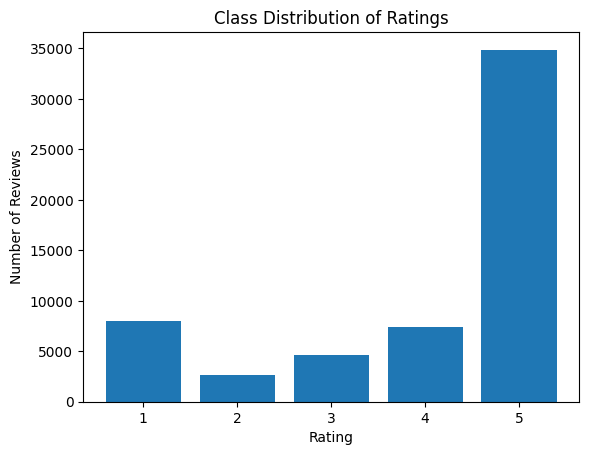

The class distribution is not balanced.


In [6]:
# Count the number of reviews for each rating class
rating_counts = data['Rating'].value_counts().sort_index()

# Plot the bar chartr
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Class Distribution of Ratings')
plt.show()

# Check if the class distribution is balanced
threshold = 0.1  # Set a threshold to determine balance
max_class_count = rating_counts.max()
min_class_count = rating_counts.min() 

if (max_class_count - min_class_count) / max_class_count < threshold:
    print("The class distribution is balanced.")
else:
    print("The class distribution is not balanced.")

There are more **positive reviews** with ratings of 3 or higher.

---

# 2. Data Preprocessing

- Use the provided "clean_data" function to **remove unnecessary symbols** and clean the dataset.



In [7]:
import re

def clean_data(text):
    # Check if the input is a string; 
    # if not, return an empty string or keep the original value
    if not isinstance(text, str):
        return ''
    text = text.lower()
        
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'br', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\b(\w)\1{2,}\b', '', text)

    return text

In [8]:
# Apply the cleaning function to the "Review" column
data['Cleaned_Review'] = data["Review"].apply(clean_data)

In [9]:
data[['Review', 'Cleaned_Review']].head(5)

,Review,Cleaned_Review
0,Thanks a lot I feel very good when i have down...,thanks a lot i feel very good when i have down...
1,Its worst,its worst
2,Used too much space,used too much space
3,Doesn't work a bit on my moto g,doesn t work a bit on my moto g
4,Hate it This does not work,hate it this does not work


## Train-Test Split

- Split the clean dataset into separate train and test sets. For this, use the "Review" field as the feature vector (X) and the "Rating" field as the label vector (Y).

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# define random state to make random processes reproducible
random_state = np.random.RandomState(0)

In [26]:
# Define X(features vector) and y(label vector)
X = data['Cleaned_Review']
y = data["Rating"]

# split the data into train-test split where 30% of data will be used as test set
train_data, test_data, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Representing Text as Bag of Words (BOW)


- Transform the cleaned data into a numerical representation using Bag of Words (BoW) and remove any stop words. Save the BoW representation in the variables train_data_BOW and test_data_BOW.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
import nltk


nltk.download('stopwords')
nltk.download('omw-1.4') 
nltk.download('wordnet') 


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/s4778158/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/s4778158/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/s4778158/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
all_stop_words = []
for lang in stopwords.fileids():
    all_stop_words.extend(stopwords.words(lang))
all_stop_words.extend(['app','apps'])

# Fill NaN values with empty strings in train_data and test_data
train_data = train_data.fillna('')
test_data = test_data.fillna('')

# Initialize CountVectorizer with the stop words
vectorizer = CountVectorizer(stop_words=all_stop_words,min_df=2, token_pattern=r'\b[a-zA-Z]{3,}\b')

# Fit and transform the training data using Bag of Words (BoW)
train_data_BOW = vectorizer.fit_transform(train_data)

# Transform the testing data using the same vectorizer
test_data_BOW = vectorizer.transform(test_data)

# visualize BOW 
training_data_BOW = pd.DataFrame(data=train_data_BOW.toarray(), columns=vectorizer.get_feature_names_out()).T

# display the last few rows of the dataframe
training_data_BOW.head(10)                                     

,0,1,2,3,4,5,6,7,8,9,...,40319,40320,40321,40322,40323,40324,40325,40326,40327,40328
aahe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aali,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aapp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaps,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aayush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abdul,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abhijeet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, the row labels are list of words extracted from the reviews and column labels are review numbers for the training data. The value inside the dataframe indicates number of occurrences of a particular word in the given reviews.

## Visualize Text Using Word Cloud

In [29]:
!pip install wordcloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


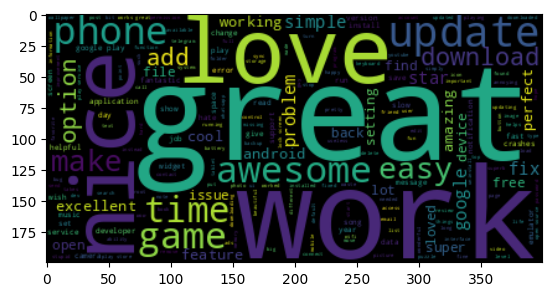

In [30]:
text = " ".join(train_data)
word_cloud = WordCloud(stopwords=set(all_stop_words)).generate(text)
plt.imshow(word_cloud, interpolation='bilinear');

Some words such as 'great', 'work', 'love', 'nice', etc. are frequently occuring in the tweets from train data set.

---

# 3. Model Training

Define 2 Logistic Regression models: *model1* and *model2* and train the models as follows:
- Train the first Logistic Regression model to predict the application rating (Y).


In [17]:
from sklearn.linear_model import LogisticRegression

- Create an additional binary label by assigning ‘1’ – positive for the product ratings 4 and 5; and "–1" for product ratings 1, 2 and 3. Store it in y_train_binary and y_test_binary.

*Tip: you can use a function copy.deepcopy for creating a copy of label variables*

In [18]:
import copy

In [19]:
# define logsitic regression model object
log_reg = LogisticRegression(random_state=random_state, max_iter=1000)
model1 = log_reg

# fit the model to training data
model1.fit(train_data_BOW, y_train)

# create sentiment binary labels: 1 for positive (rating 4 and 5), -1 for negative (rating 1, 2, 3)
y_train_binary = copy.deepcopy(y_train)
y_train_binary = y_train_binary.apply(lambda x: 1 if x >= 4 else -1)

y_test_binary = copy.deepcopy(y_test)
y_test_binary = y_test_binary.apply(lambda x: 1 if x >= 4 else -1)

- Train the second Logistic Regression model to predict the binary sentiment label (Y_binary).


In [20]:
# train the second logistic regression model: for predicting sentiment classification
model2 = LogisticRegression(random_state=random_state, max_iter=1000)  

# fit the model to training data
model2.fit(train_data_BOW, y_train_binary) 

LogisticRegression(max_iter=1000,
                   random_state=RandomState(MT19937) at 0x7FFF69335540)


- Make and store predictions for both models

In [21]:
# make predictions for both models
y_pred_model1 = model1.predict(test_data_BOW)  # rating prediction
y_pred_model2 = model2.predict(test_data_BOW)  # binary sentiment prediction

---

# 4. Model Evaluation

- Compute and compare the test accuracy of Model 1 and Model 2. Based on your results, analyze which task is easier: binary sentiment prediction or multi-class rating prediction.

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# calculate and print the accuracy of Model 1 and Model 2
accuracy_model1 = accuracy_score(y_test, y_pred_model1)
accuracy_model2 = accuracy_score(y_test_binary, y_pred_model2)
print(f"Model 1 Rating Prediction Accuracy Score: {accuracy_model1:.4f}")
print(f"Model 2 Sentiment Label Accuracy Score: {accuracy_model2:.4f}")

Model 1 Rating Prediction Accuracy Score: 0.6604
Model 2 Sentiment Label Accuracy Score: 0.8213


These results show that, in comparison to Model 1 (multi-class rating prediction), Model 2 (binary sentiment prediction) has a greater accuracy. This implies that the model finds it easier to predict binary emotion than multi-class ratings.

Analysis: Binary sentiment prediction (positive/negative) is often simpler because it simply entails distinguishing between two groups. There should be less choice boundaries in the model's focus. However, multi-class rating prediction raises the job complexity and decreases accuracy by requiring the model to distinguish between many classes (ratings from 1 to 5).



- For Model 1,  compute additional evaluaton measures, namely confusion matrix, precision and recall.  

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# calculate additional evaluation indicators for Model 1: precision, recall, confusion matrix
print("\nModel 1 (Rating Prediction) Specific Evaluation Report：")
print(classification_report(y_test, y_pred_model1))

conf_matrix_model1 = confusion_matrix(y_test, y_pred_model1)
print("\nModel 1 Confusion Matrix：")
print(conf_matrix_model1)

# calculate the number of samples that actually scored 5 but were misclassified as 1
misclassified_as_1 = conf_matrix_model1[4, 0]  
print(f"\n Number of classficated with mistake to rating of 1, actual rating of 5: {misclassified_as_1}")


Model 1 (Rating Prediction) Specific Evaluation Report：
              precision    recall  f1-score   support

           1       0.61      0.45      0.52      2475
           2       0.19      0.07      0.10       790
           3       0.23      0.07      0.11      1372
           4       0.32      0.11      0.16      2192
           5       0.71      0.95      0.81     10455

    accuracy                           0.66     17284
   macro avg       0.41      0.33      0.34     17284
weighted avg       0.58      0.66      0.60     17284


Model 1 Confusion Matrix：
[[1117   91   87   63 1117]
 [ 226   55   63   66  380]
 [ 193   68  100  130  881]
 [ 113   35   90  233 1721]
 [ 185   40   93  228 9909]]

 Number of classficated with mistake to rating of 1, actual rating of 5: 185


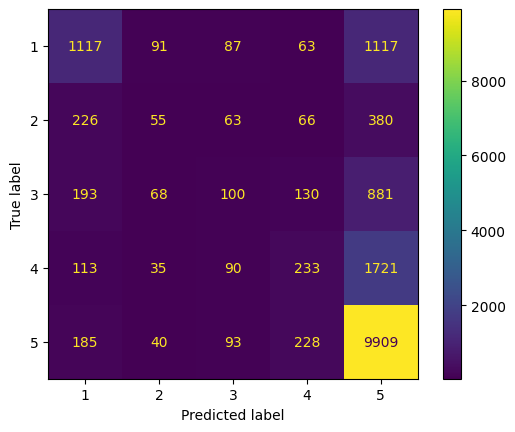

In [33]:
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_model1 , display_labels=model1.classes_)
display.plot();

The accuracy of Model 1 is 0.66(0.6597), according to the accuracy and confusion matrix; nevertheless, accuracy by itself is insufficient to assess the model's performance. To get a deeper understanding of the model's performance across classes, we also need to take other measures like precision and recall into account.

With precisions of 0.61 and 0.71 for ratings 1 and 5, respectively, the model performs well in terms of precision; but, its precision for ratings 2, 3, and 4 is low, particularly for ratings 2 and 3, with precisions of 0.19 and 0.22.

The majority of samples with an actual rating of 5 are accurately classified according to the model, which has an extremely high recall for rating 5 (0.95). Recalls for other ratings, notably ratings 2, 3, and 4, are comparatively modest, with recalls less than 0.15.

- Based on the confusion matrix obtained in the previous question (referring to Model 1, the Logistic Regression for rating prediction), identify and state the number of samples that were classified to have the rating of 1 (the lowest rating), but in reality, they had an actual rating of 5 (the highest rating).

In the confusion matrix for Model 1 (Logistic Regression), **185** samples were classified as having a rating of 1, but in fact, they had an actual rating of 5，in the row for true label 5 and the column for predicted label 1 . This indicates a significant misclassification issue, where the model fails to distinguish between the lowest and highest ratings. This suggests that the algorithm occasionally fails to discern between high and low ratings, which could cause customers' input to be seriously misinterpreted.

---

# 5. Model Analysis

- Discuss the importance of considering alternative evaluation measures, such as precision and recall, instead of relying solely on accuracy. Based on this discussion, identify the most suitable evaluation metric for Model 

Despite having an accuracy of 0.66, Model 1's performance is not fully represented by this number. The model suffers with lower ratings, but it does well on higher ratings such as 5). In imbalanced datasets, precision and recall are more significant measurements, particularly when we are concerned with particular classes, such as ratings 1 or 5.

Weighted accuracy and recall would be more acceptable evaluation metrics for Model 1, given the imbalanced class distribution, since they more accurately reflect the model's performance across all classes.


- For binary sentiment prediction (Model 2), visualize important words with their model coefficients.  

*Tip: you can reuse the function plot_coefficients from prac. session.*

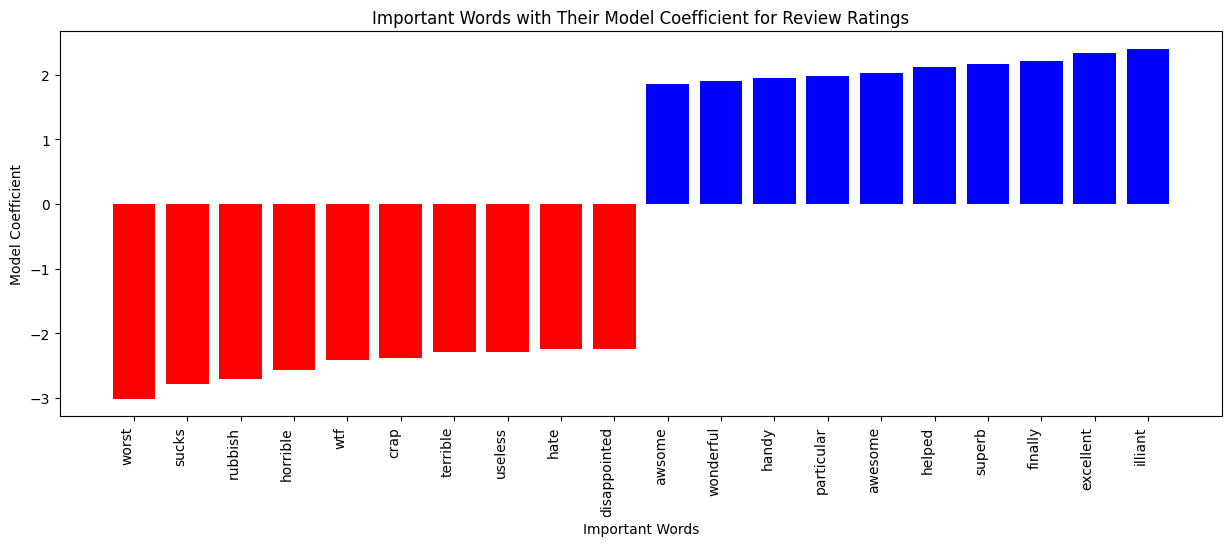

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# visualizing the most important words and their coefficients in the logistic regression model
def plot_coefficients(classifier, feature_names, top_features=10):
    """
    Visualize the most important words for positive and negative classes in the sentiment analysis model.
    
    classifier: Trained Logistic Regression classifier
    feature_names: List of feature names (words)
    top_features: Number of top features to display
    """
    coef = classifier.coef_.ravel()  #  get the model's coefficients
    top_positive_coefficients = np.argsort(coef)[-top_features:]  # select top words for positive sentiment
    top_negative_coefficients = np.argsort(coef)[:top_features]  # select top words for negative sentiment
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])  # Combine both sets

    # create the plot
    plt.figure(figsize=(15, 5))
    colors = ['blue' if c > 0 else 'red' for c in coef[top_coefficients]]  # blue for positive, red for negative
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    
    feature_names = np.array(feature_names)  # convert feature names to a numpy array
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    plt.xlabel("Important Words")
    plt.ylabel("Model Coefficient")
    plt.title("Important Words with Their Model Coefficient for Review Ratings")
    plt.show()

# visualize the most important words in Model 2 for review rating prediction
plot_coefficients(model2, vectorizer.get_feature_names_out(), top_features=10)


- Analyze the quality of the features produced by Model 2 by examining the words with the highest coefficients for both the positive and negative classes.  Identify any potential bias in the model, and explain how this bias could affect its performance.

The words that have the biggest influence on emotion prediction can be determined by looking at the coefficients in Model 2. Those with good sentiment have larger coefficients of positivity, and those with negative sentiment have higher  negative coefficients.

Potential Bias:
Certain high-frequency terms may tend get higher weights in the model, which may not adequately reflect emotion. For instance, if the model relies too much on a few frequent terms, it might not take into account how differently they can signify in different situations. This bias may cause particular categories' predictions to be off, which would have an impact on the performance as a whole.

Twenty words are depicted in the plot, and they were crucial in helping to make predictions. The top 10 terms with negative model coefficient values are displayed in red bars; these words are strongly linked to negative evaluations (lower ratings). Words with significant negative coefficients, such as "worst," "sucks," "rubbish," "horrible," and "useless," increase the likelihood that a review will be rated lower.  

The top 10 terms with positive model coefficient values—which are strongly connected with favourable reviews and better ratings—are displayed as blue bars. Strong positive coefficients indicate that terms like "brilliant," "excellent," "awesome," "wonderful," and "superb" are frequently seen in evaluations with higher ratings. 

This graphic demonstrates how specific words have a significant impact on the model's sentiment classification and rating prediction.